In [74]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logit
from scipy.stats import norm

import tensorflow as tf
from keras import layers, models, datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PowerTransformer
from sklearn.metrics import f1_score, log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression

import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

An interpolation based learning technique, driven through explicit regularization

In [75]:
def calculate_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, f1

In [76]:
class CustomDataLoader:
    def __init__(self, features, labels, batch_size=1, validation_size=0.0, raw_output=None):
        train_indices, val_indices, train_labels, val_labels = train_test_split(
            range(len(labels)), labels, test_size=0.2, stratify=labels, random_state=42
        )
    
        train_data = features[train_indices]
        val_data = features[val_indices]

        self.train_data_tensor = torch.tensor(train_data).float().to(device)
        self.train_labels_tensor = torch.tensor(train_labels).long().to(device)

        sorted_train_data_tensor, sorted_indices = torch.sort(self.train_data_tensor[:, 0])
        self.train_data_tensor = self.train_data_tensor[sorted_indices]
        self.train_labels_tensor = self.train_labels_tensor[sorted_indices]

        if raw_output is None:
            self.raw_output_train = None
            self.raw_output_val = None
        else:
            self.raw_output_train = raw_output[train_indices].clone().detach().float().to(device)
            self.raw_output_val = raw_output[val_indices].clone().detach().float().to(device)

        self.val_data_tensor = torch.tensor(val_data).float().to(device)
        self.val_labels_tensor = torch.tensor(val_labels).long().to(device)

        train_dataset = TensorDataset(self.train_data_tensor, self.train_labels_tensor)
        val_dataset = TensorDataset(self.val_data_tensor, self.val_labels_tensor)

        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    def get_train_loader(self):
        return self.train_loader
    
    def get_val_loader(self):
        return self.val_loader

In [377]:
def evaluate_model(model, custom_train_loader, criterion, optimizer):
    num_epochs = 2000
    unregularized_criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in custom_train_loader.get_train_loader():        
            optimizer.zero_grad()
            outputs = model(inputs.view(-1, 1))

            loss = criterion(outputs, labels, model.copy_tensor)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        if (epoch + 1) % 100 == 0:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_inputs, val_labels in custom_train_loader.get_val_loader():
                    val_outputs = model(val_inputs.view(-1, 1))
                    val_loss += unregularized_criterion(val_outputs, val_labels).item()

            avg_train_loss = running_loss / len(custom_train_loader.get_train_loader())
            avg_val_loss = val_loss / len(custom_train_loader.get_val_loader())

            train_accuracy, train_f1 = calculate_metrics(model, custom_train_loader.get_train_loader())
            val_accuracy, val_f1 = calculate_metrics(model, custom_train_loader.get_val_loader())

            print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
            print(f'Training Accuracy: {train_accuracy}, Training F1 Score: {train_f1}')
            print(f'Validation Accuracy: {val_accuracy}, Validation F1 Score: {val_f1}')
            print()

In [378]:
class CustomLoss(nn.Module):
    def __init__(self, base_loss_fn, first_order_weight=0.0, second_order_weight=0.0):
        super(CustomLoss, self).__init__()
        self.first_order_weight = first_order_weight
        self.second_order_weight = second_order_weight
        self.base_loss_fn = base_loss_fn

    def forward(self, outputs, labels, optimized_tensor):
        base_loss = self.base_loss_fn(outputs, labels)

        first_order_x = (optimized_tensor[:-1] - optimized_tensor[1:])
        first_order_loss = self.first_order_weight * torch.sum(first_order_x ** 2)

        second_order_x = (first_order_x[1:] - first_order_x[:-1])
        second_order_loss = self.second_order_weight * torch.sum(second_order_x ** 2)

        return base_loss + first_order_loss + second_order_loss

In [469]:
data = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')
"""data = data.dropna()"""

"""
X = data.drop(["Cover_Type"], axis=1)
"""
X = data[["radius_worst"]]
y = data["diagnosis"]

X = pd.get_dummies(X, drop_first=True)
for col in X.columns:
    if (X[col] > 0).all():
        X[col] = np.log(X[col])

print(X.shape)

print(X.shape, y.shape)
print(data.columns)

(569, 1)
(569, 1) (569,)
Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


In [470]:
x_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [476]:
class TestClass(torch.nn.Module):
    def __init__(self, copy_tensor):
        super(TestClass, self).__init__()
        self.copy_tensor = torch.nn.Parameter(torch.zeros_like(copy_tensor, requires_grad=True))

    def forward(self, x):
        print(x.shape)
        opposite_tensor = self.copy_tensor * -1
        combined_tensor = torch.cat((self.copy_tensor, opposite_tensor), dim=1)
        print(combined_tensor.shape)
        return combined_tensor

In [500]:
class TestClass(torch.nn.Module):
    def __init__(self, copy_tensor):
        super(TestClass, self).__init__()
        self.control_points = 100
        self.copy_tensor = nn.Parameter(torch.zeros(self.control_points + 2))

    def forward(self, x):        
        scaled_x = x * self.control_points
        lower_idx = torch.floor(scaled_x).long()
        upper_idx = lower_idx + 1

        lower_value = self.copy_tensor[lower_idx]
        upper_value = self.copy_tensor[upper_idx]

        interpolated_value = lower_value + (upper_value - lower_value) * (scaled_x - lower_idx.float())
        combined_tensor = torch.cat((interpolated_value, interpolated_value * -1), dim=1)
        return combined_tensor

In [501]:
num_epochs = 1
num_features = 1
num_classes = 2

custom_train_loader = CustomDataLoader(x_scaled, y_encoded, batch_size=1024, validation_size=0.2)
model = TestClass(custom_train_loader.train_data_tensor)

criterion = CustomLoss(nn.CrossEntropyLoss(), first_order_weight=0.001 * 10, second_order_weight=0.001 * 10)
optimizer = optim.Adam(model.parameters(), lr=0.1)

for name, param in model.named_parameters():
    break
    print(f"Layer: {name}")
    print(f"Shape: {param.shape}")
    print(param)

In [502]:
optimizer = optim.Adam(model.parameters(), lr=0.001 * 10)
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch 100, Training Loss: 0.3028946816921234, Validation Loss: 0.31212297081947327
Training Accuracy: 0.9186813186813186, Training F1 Score: 0.9175862826752187
Validation Accuracy: 0.9035087719298246, Validation F1 Score: 0.9013593586615545

Epoch 200, Training Loss: 0.23864346742630005, Validation Loss: 0.24322210252285004
Training Accuracy: 0.9186813186813186, Training F1 Score: 0.9175862826752187
Validation Accuracy: 0.9035087719298246, Validation F1 Score: 0.9013593586615545

Epoch 300, Training Loss: 0.22134289145469666, Validation Loss: 0.22161965072155
Training Accuracy: 0.9208791208791208, Training F1 Score: 0.9198787016000859
Validation Accuracy: 0.9035087719298246, Validation F1 Score: 0.9013593586615545

Epoch 400, Training Loss: 0.214746356010437, Validation Loss: 0.21228283643722534
Training Accuracy: 0.9208791208791208, Training F1 Score: 0.9198787016000859
Validation Accuracy: 0.9035087719298246, Validation F1 Score: 0.9013593586615545

Epoch 500, Training Loss: 0.211659

In [503]:
# First order fixed to 0.001 * 10

# Second_order = 0.001 * 100
# Epoch 1000, Training Loss: 0.21387068927288055, Validation Loss: 0.20096205174922943
# Training Accuracy: 0.9252747252747253, Training F1 Score: 0.9244497970322773
# Validation Accuracy: 0.9035087719298246, Validation F1 Score: 0.9013593586615545

# Second_order = 0.001 * 10
# Epoch 1000, Training Loss: 0.2082907110452652, Validation Loss: 0.19897226989269257
# Training Accuracy: 0.9186813186813186, Training F1 Score: 0.9175862826752187
# Validation Accuracy: 0.9035087719298246, Validation F1 Score: 0.9013593586615545

# Second_order = 0.001 * 1
# Epoch 1000, Training Loss: 0.20646148920059204, Validation Loss: 0.199349507689476
# Training Accuracy: 0.9208791208791208, Training F1 Score: 0.9198787016000859
# Validation Accuracy: 0.9035087719298246, Validation F1 Score: 0.9013593586615545

# Second_order = 0.001 * 0.1
# Epoch 1000, Training Loss: 0.20624913275241852, Validation Loss: 0.1994982212781906
# Training Accuracy: 0.9208791208791208, Training F1 Score: 0.9198787016000859
# Validation Accuracy: 0.9035087719298246, Validation F1 Score: 0.9013593586615545

# Second_order = 0.0
# Epoch 1000, Training Loss: 0.2061692625284195, Validation Loss: 0.19947375357151031
# Training Accuracy: 0.9208791208791208, Training F1 Score: 0.9198787016000859
# Validation Accuracy: 0.9035087719298246, Validation F1 Score: 0.9013593586615545


In [504]:
# First_order

# 0.001 * 100
# Epoch 1000, Training Loss: 0.24796029925346375, Validation Loss: 0.21686182916164398
# Training Accuracy: 0.9252747252747253, Training F1 Score: 0.9244497970322773
# Validation Accuracy: 0.9035087719298246, Validation F1 Score: 0.9013593586615545

# 0.001 * 10
# Epoch 1000, Training Loss: 0.2061692625284195, Validation Loss: 0.19947375357151031
# Training Accuracy: 0.9208791208791208, Training F1 Score: 0.9198787016000859
# Validation Accuracy: 0.9035087719298246, Validation F1 Score: 0.9013593586615545

# 0.001 * 1
# Epoch 1000, Training Loss: 0.18999454379081726, Validation Loss: 0.20367243885993958
# Training Accuracy: 0.9252747252747253, Training F1 Score: 0.9244497970322773
# Validation Accuracy: 0.9035087719298246, Validation F1 Score: 0.9013593586615545

# 0.0
# Epoch 1000, Training Loss: 0.15905149281024933, Validation Loss: 0.32406866550445557
# Training Accuracy: 0.9340659340659341, Training F1 Score: 0.9332322513334049
# Validation Accuracy: 0.9035087719298246, Validation F1 Score: 0.9013593586615545

In [505]:
X_train = custom_train_loader.train_data_tensor.cpu().numpy()
y_train = custom_train_loader.train_labels_tensor.cpu().numpy()
X_val = custom_train_loader.val_data_tensor.cpu().numpy()
y_val = custom_train_loader.val_labels_tensor.cpu().numpy()

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_val_pred = log_reg.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

train_log_loss = log_loss(y_train, log_reg.predict_proba(X_train))
val_log_loss = log_loss(y_val, log_reg.predict_proba(X_val))

print(f'Training Accuracy: {train_accuracy}')
print(f'Training Log Loss: {train_log_loss}')
print()
print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation Log Loss: {val_log_loss}')

Training Accuracy: 0.9054945054945055
Training Log Loss: 0.30924995810498046

Validation Accuracy: 0.8859649122807017
Validation Log Loss: 0.3196697841465369


In [506]:
print(model.copy_tensor.shape)
print(custom_train_loader.train_data_tensor.shape)
print(model.copy_tensor)

torch.Size([102])
torch.Size([455, 1])
Parameter containing:
tensor([ 2.7865,  2.7857,  2.7850,  2.7842,  2.7835,  2.7828,  2.7818,  2.7805,
         2.7788,  2.7763,  2.7729,  2.7685,  2.7632,  2.7565,  2.7484,  2.7391,
         2.7278,  2.7146,  2.6990,  2.6802,  2.6581,  2.6313,  2.5987,  2.5592,
         2.5123,  2.4589,  2.3980,  2.3284,  2.2443,  2.1440,  2.0233,  1.8886,
         1.7611,  1.6763,  1.5995,  1.5834,  1.5827,  1.5903,  1.5695,  1.4820,
         1.3281,  1.1603,  0.9616,  0.7930,  0.6403,  0.4600,  0.3554,  0.3266,
         0.2953,  0.1986, -0.0140, -0.2063, -0.3947, -0.5734, -0.7265, -0.8662,
        -1.0706, -1.2513, -1.3921, -1.4950, -1.5772, -1.6858, -1.8224, -1.9537,
        -2.0700, -2.1701, -2.2579, -2.3356, -2.4052, -2.4673, -2.5217, -2.5686,
        -2.6094, -2.6451, -2.6762, -2.7023, -2.7250, -2.7444, -2.7604, -2.7739,
        -2.7855, -2.7960, -2.8056, -2.8144, -2.8220, -2.8286, -2.8345, -2.8398,
        -2.8445, -2.8486, -2.8518, -2.8544, -2.8566, -2.858

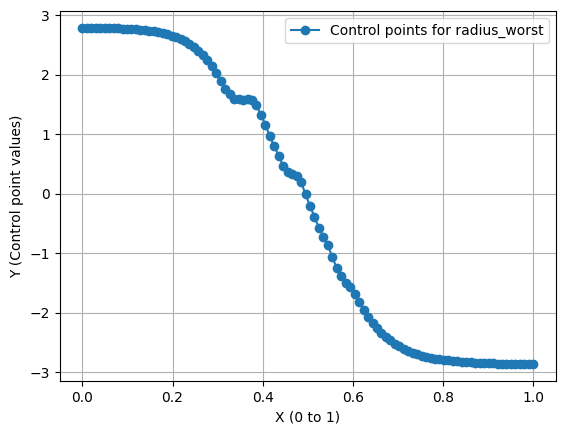

In [512]:
y = model.copy_tensor
x_values = np.linspace(0, 1, len(y))

plt.plot(x_values, y.detach().cpu().numpy(), marker='o', label='Control points for radius_worst')
plt.xlabel('X (0 to 1)')
plt.ylabel('Y (Control point values)')
plt.grid(True)
plt.legend()
plt.show()